In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass
import os
from sklearn.neighbors import KDTree

In [2]:
with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [3]:
temp = np.load('stars_from_catsim.npz')
catsim_data = temp['from_catsim'].copy()
temp.close()

In [4]:
catsim_data

array([( 3500., -1.,  4.5,  29.15061  ,  27.86252  ,  26.88286  ),
       ( 2700., -0.,  2. ,  27.6896   ,  26.25251  ,  24.4602   ),
       ( 3400., -1.,  4.5,  22.9489   ,  21.66766  ,  20.55609  ), ...,
       ( 8950.,  1.,  3.5,  13.386506 ,  13.4968833,  13.6648923),
       ( 9200.,  1.,  4. ,  19.0695859,  19.1674051,  19.3290885),
       ( 8540.,  1.,  3.5,  14.2749375,  14.329094 ,  14.4727031)],
      dtype=[('teff', '<f8'), ('metallicity', '<f8'), ('logg', '<f8'), ('gmag', '<f8'), ('rmag', '<f8'), ('imag', '<f8')])

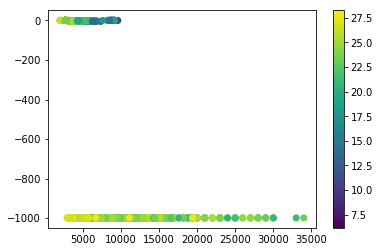

In [5]:
# Let's make sure our model parameter spaces are a reasonable match
plt.scatter(catsim_data['teff'], catsim_data['metallicity'], c=catsim_data['rmag'])
cb = plt.colorbar()

In [6]:
np.where(catsim_data['metallicity'] < -900)[0].size, catsim_data.size

(5374, 127426)

In [7]:
# ok, so 5k of the 127k have something that looks like a mask value of -999. Make a note to ask Scott what is up with that,
# but we'll just cut those for now.
catsim_data = catsim_data[np.where(catsim_data['metallicity'] > -900)]

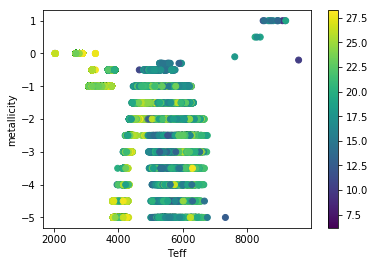

In [8]:
plt.scatter(catsim_data['teff'], catsim_data['metallicity'], c=catsim_data['rmag'])
cb = plt.colorbar()
plt.xlabel('Teff')
plt.ylabel('metallicity')

In [9]:
# I'm a little confused, those seem like amazingly low metallicity values for a lot of stars. 
# We'll go ahead and treat all of those like the minimum metallicity in our models.

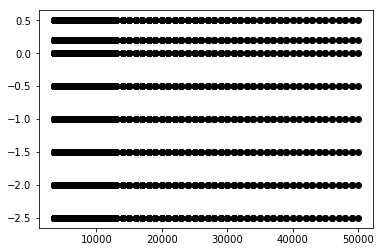

In [10]:
plt.plot(model_atm_mags['Teff'], model_atm_mags['log_Z'], 'ko')

In [11]:
# Now to match the catsim properties up to our model properties

# normalize all the parameters
temp_norm = np.max(model_atm_mags['Teff'])
met_norm = np.max(model_atm_mags['log_Z'] ) - np.min(model_atm_mags['log_Z'])
logg_norm = np.max(model_atm_mags['gravity'] ) - np.min(model_atm_mags['gravity'])

model_X = np.array([model_atm_mags['Teff']/temp_norm,
                       model_atm_mags['log_Z']/met_norm,
                       model_atm_mags['gravity']/logg_norm]).T

model_kd_tree = KDTree(model_X)

In [12]:
# now to lookup the closest model index for each catsim star
catsim_vals = np.array([catsim_data['teff']/temp_norm,
              catsim_data['metallicity']/met_norm,
              catsim_data['logg']/logg_norm]).T
dist, indx_match = model_kd_tree.query(catsim_vals, k=1)

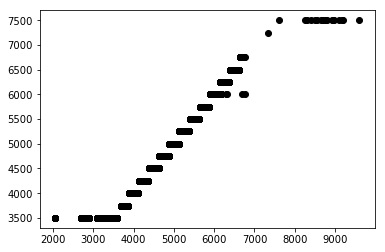

In [13]:
# check that we did kinda match things up in a reasonable way.
plt.plot(catsim_data['teff'], model_atm_mags['Teff'][indx_match], 'ko')

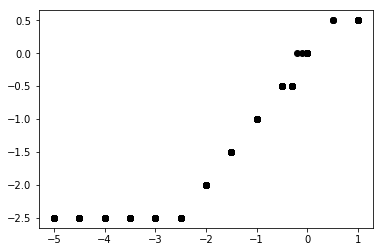

In [14]:
plt.plot(catsim_data['metallicity'], model_atm_mags['log_Z'][indx_match], 'ko')

In [15]:
# Let's construct a realistic catalog of stars with all the info from the model atmospheres
mag_cols = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'u',
            'g', 'r', 'i', 'z', 'y']

In [16]:
truth_catalog = model_atm_mags[indx_match.ravel()]

In [17]:
dist_modulus = truth_catalog['r'] - catsim_data['rmag']

In [18]:
dist_modulus

array([-63.15321237, -61.06722329, -56.95835237, ..., -53.22021762,
       -58.89073942, -54.05242832])

In [19]:
for mag_col in mag_cols:
    truth_catalog[mag_col] -= dist_modulus

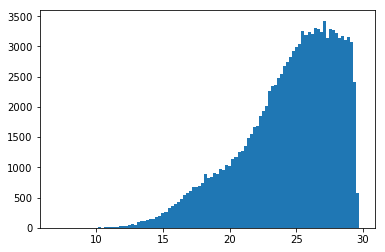

In [20]:
ack = plt.hist(truth_catalog['g'], bins=100)

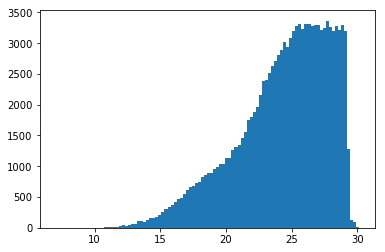

In [21]:
ack = plt.hist(catsim_data['gmag'], bins=100)

In [22]:
# OK, those look pretty similar, the magnitudes in our new truth table have the same distribution as catsim


The next steps:

First, we need to make 2 kd-trees using the data in model_atm_mags. 1) a tree that lets one find the nearest model using (u-g), (g-r), (r-i), (i-z), (z-y). 2) a tree with those same broad colors, and also narrow colors. Maybe as (F378-u), (F395-u), (F861-i), etc where you use the broad band that covers the narrow band. 

Then, generate a realization of the magnitudes that LSST would observe (basically adding noise to the truth_catalog). We need to lookup the depths to figure out how much noise.

Finally, compare how well we recover the truth teff, metallicity, etc using each of the kd trees. 